In [11]:
from tqdm import tqdm
import torch
import numpy as np
import scanpy as sc
from omegaconf import OmegaConf
from cfgen.data.scrnaseq_loader import RNAseqLoader
from cfgen.models.base.encoder_model import EncoderModel
from scvi.distributions import NegativeBinomial

In [12]:
dataset_conf = OmegaConf.load("../../configs/configs_encoder/dataset/neurips.yaml")
encoder_conf = OmegaConf.load("../../configs/configs_encoder/encoder/default.yaml")

In [13]:
dataset = RNAseqLoader(dataset_conf.dataset_path,
                        layer_key=dataset_conf.layer_key,
                        covariate_keys=dataset_conf.covariate_keys,
                        subsample_frac=dataset_conf.subsample_frac, 
                        normalization_type=dataset_conf.normalization_type,
                        is_binarized=dataset_conf.is_binarized)

dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=64,
                                        shuffle=False,
                                        drop_last=False)

/home/icb/alessandro.palma/miniconda3/envs/cfgen/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
gene_dim = {mod: dataset.X[mod].shape[1] for mod in dataset.X}

encoder_model = EncoderModel(in_dim=gene_dim,
                              n_cat=None,
                              conditioning_covariate=dataset_conf.theta_covariate, 
                              **encoder_conf)

In [15]:
state_dict_path = "../../project_folder/experiments/autoencoder_ckpt/train_autoencoder_neurips_final/checkpoints/last.ckpt"
encoder_model.load_state_dict(torch.load(state_dict_path, weights_only=False)["state_dict"])

<All keys matched successfully>

In [25]:
X_merged = []
labels = []

with torch.no_grad():
    for batch in tqdm(dataloader):
        size_factor = {"rna": batch["X"]["rna"].sum(1).unsqueeze(1)}
        z = encoder_model.encode(batch)
        mu_hat = encoder_model.decode(z, size_factor)
        X_hat = NegativeBinomial(mu=mu_hat["rna"], theta=torch.exp(encoder_model.theta)).sample()

        X_merged.append(batch["X"]["rna"].numpy())
        X_merged.append(X_hat.numpy())
        labels.extend(["Real" for _ in range(len(batch["X"]["rna"]))])
        labels.extend(["Generated" for _ in range(len(X_hat))])

100%|██████████| 1129/1129 [01:48<00:00, 10.40it/s]


In [26]:
X_merged = np.concatenate(X_merged)

In [27]:
adata = sc.AnnData(X=X_merged, 
                   obs={"dataset_type": labels})

In [28]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

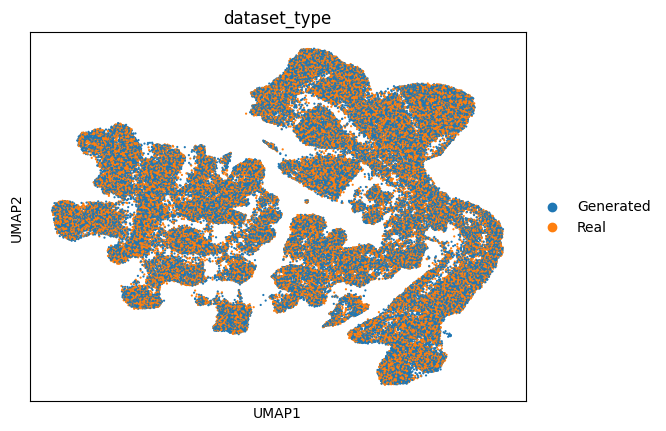

In [30]:
sc.pl.umap(adata, color="dataset_type", s=10)